In [ ]:
Machine Learning for Material Property Simulations

In [ ]:
import sys
sys.path.append('../')  # Pfad zu deinen Python-Dateien hinzufügen

from main_code import wichtige_funktion


In [ ]:
Task 1:

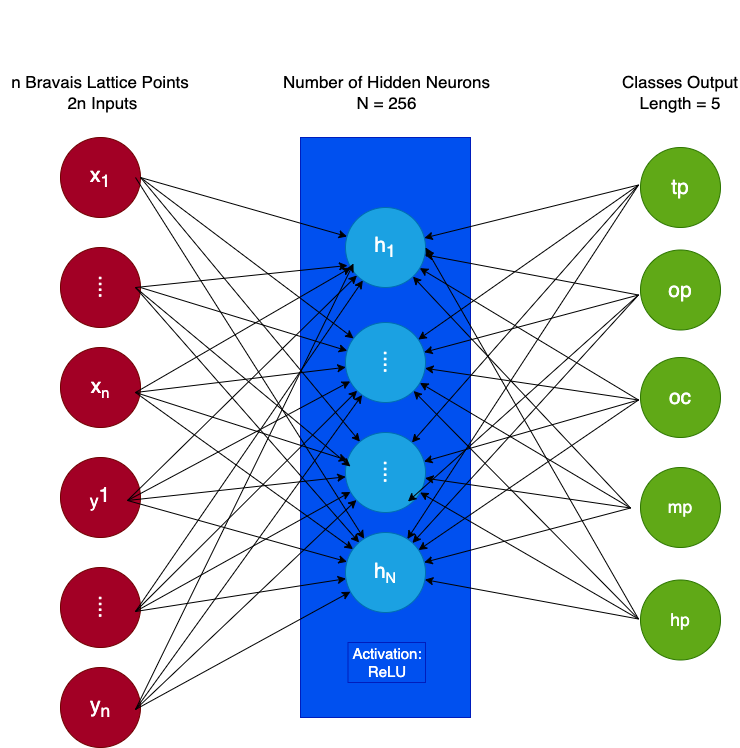

In [3]:
from IPython.display import display, Image


display(Image(filename="leed_nn_shematic_draw.png"))

In [ ]:
### Hyperparameter setting and optimization ###

BATCH_SIZE = 4 # Trial and error
N_POINTS = 320 # More like informed Guess
NUM_ITERATIONS = 2500 # Trial and error
LEARNING_RATE = 5e-2 # Trial and error
HIDDEN_DIM = 256 # Trial and error
NUM_LAYERS = 1  # Trial and error
VOCAB_SIZE = 5  # Givven by the number of Bravais types
ACTIVATION_FUNC = "ReLU" # More like informed Guess

In [8]:
Task 2:

SyntaxError: invalid syntax (2855707095.py, line 1)